### Import required libraries

In [1]:
import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import curve_fit

from IPython.display import display, Math, Latex

In [2]:
# Make the graphs bigger
matplotlib.rcParams['figure.figsize'] = (16, 8)

### Read in data from CSV files

In [3]:
# Define the names of the .csv files to be read from
file_names = [
    'no_sample/erroneous',
    'sample/erroneous',
    'no_sample/corrected',
    'sample/corrected',
]

# Save all the data from the .csv files in a dictionary
data = {}
for file_name in file_names:
    with open('MDP Data/{}/chrtusbtemp.csv'.format(file_name), 'rt') as file:
        values = csv.reader(file)
        next(values)  # Skip the headers
        data[file_name] = [val for val in values if val]

### Plot the full data series

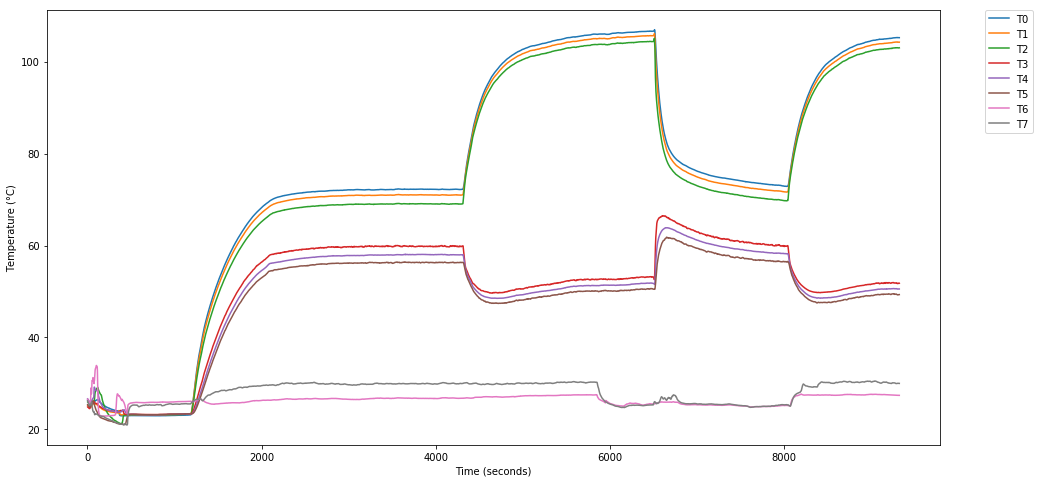

In [17]:
# The last measurement to be taken was with the Nomex sample in the erroneous conditions 
# (high ambient temperuture readings), therefore the full data series is included in this
# set as the lab software exports the data accumulatively.
x = [float(row[0]) for row in data['sample/erroneous']]
for i in range(1, 9):
    y = [float(row[i]) for row in data['sample/erroneous']]
    plt.plot(x, y, label='T{}'.format(i-1))
    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (°C)')
plt.show()

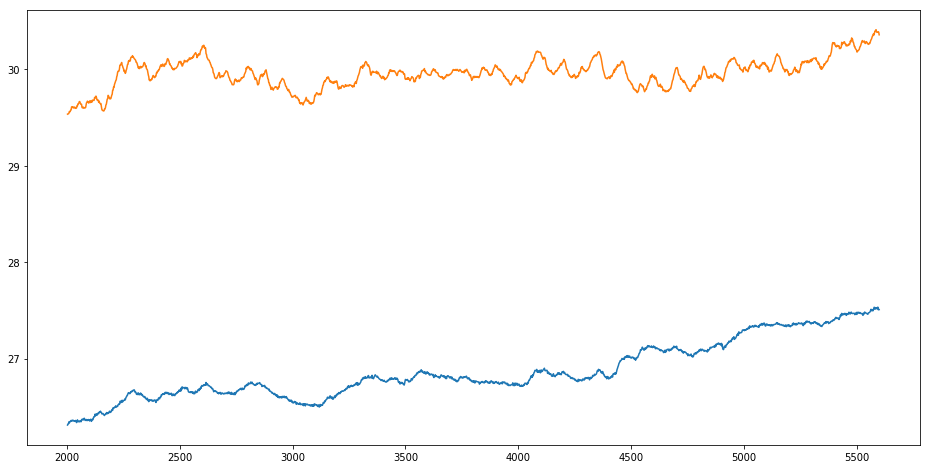

In [18]:
# Plot the high region of T6 and T7
x = [float(row[0]) for row in data['sample/erroneous']][1000:2800]
y = {}
for i in range(7, 9):
    y[i] = [float(row[i]) for row in data['sample/erroneous']][1000:2800]
    plt.plot(x, y[i])
plt.show()

In [25]:
# Calculate the average temperatures of T6 and T7
print("T6 average: {}°C".format(sum(y[7]) / len(y[7])))
print("T7 average: {}°C".format(sum(y[8]) / len(y[8])))

T6 average: 26.870650672912596°C
T7 average: 29.957843126720853°C


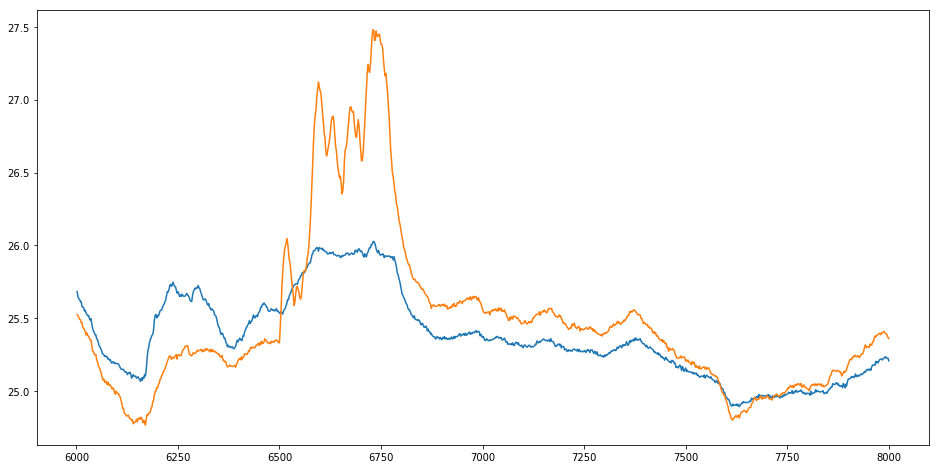

In [15]:
# Plot the corrected region of T6 and T7
x = [float(row[0]) for row in data['sample/erroneous']][3000:4000]
y = {}
for i in range(7, 9):
    y[i] = [float(row[i]) for row in data['sample/erroneous']][3000:4000]
    plt.plot(x, y[i])
plt.show()

In [26]:
# Calculate the average temperatures of T6 and T7
print("T6 average: {}°C".format(sum(y[7]) / len(y[7])))
print("T7 average: {}°C".format(sum(y[8]) / len(y[8])))

T6 average: 26.870650672912596°C
T7 average: 29.957843126720853°C


### Plot each of the four steady state regions

In [5]:
x = [float(row[0]) for row in data['no_sample/erroneous']][1000:]
for i in range(1, 7):
    y = [float(row[i]) for row in data['no_sample/erroneous']][1000:]
    plt.plot(x, y)

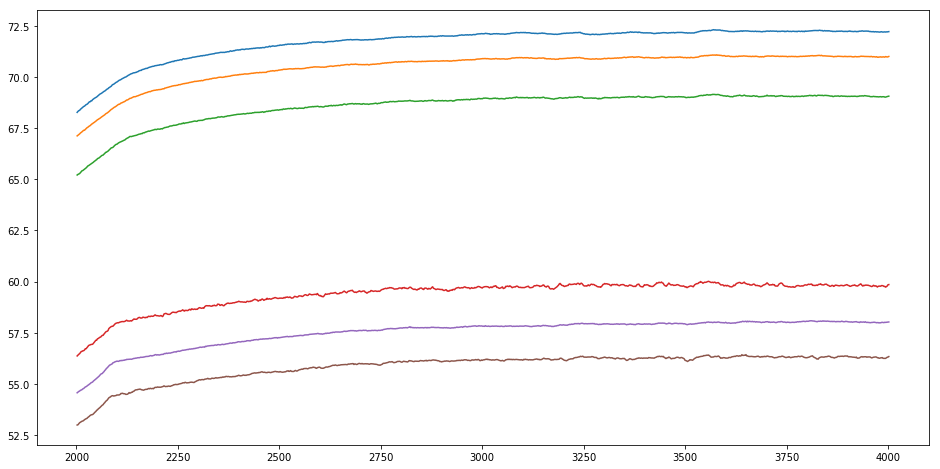

In [6]:
plt.show()

In [52]:
x = [float(row[0]) for row in data['sample/erroneous']][4300:]
for i in range(1, 7):
    y = [float(row[i]) for row in data['sample/erroneous']][4300:]
    plt.plot(x, y)

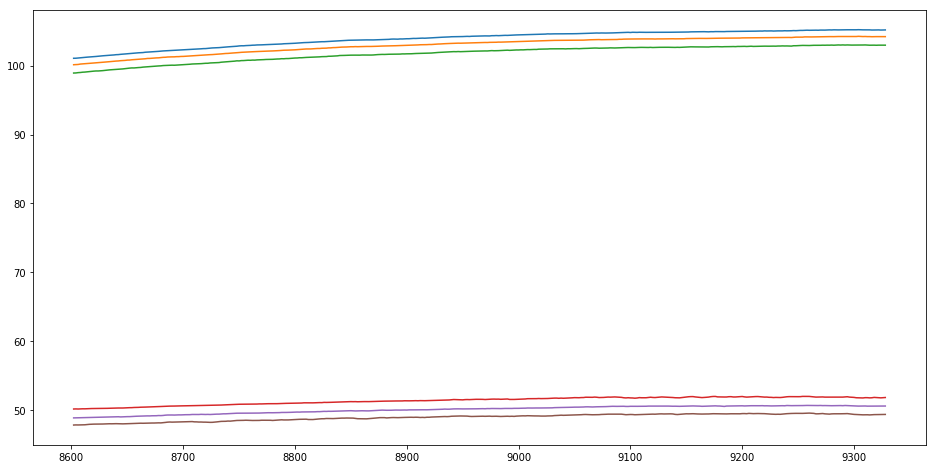

In [53]:
plt.show()

In [54]:
x = [float(row[0]) for row in data['no_sample/corrected']][3500:]
for i in range(1, 7):
    y = [float(row[i]) for row in data['no_sample/corrected']][3500:]
    plt.plot(x, y)

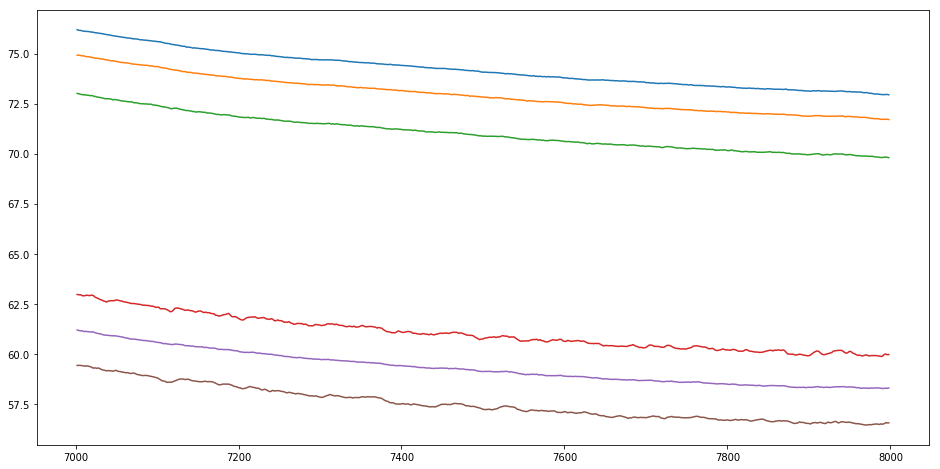

In [55]:
plt.show()

In [56]:
x = [float(row[0]) for row in data['sample/corrected']][2400:]
for i in range(1, 7):
    y = [float(row[i]) for row in data['sample/corrected']][2400:]
    plt.plot(x, y)

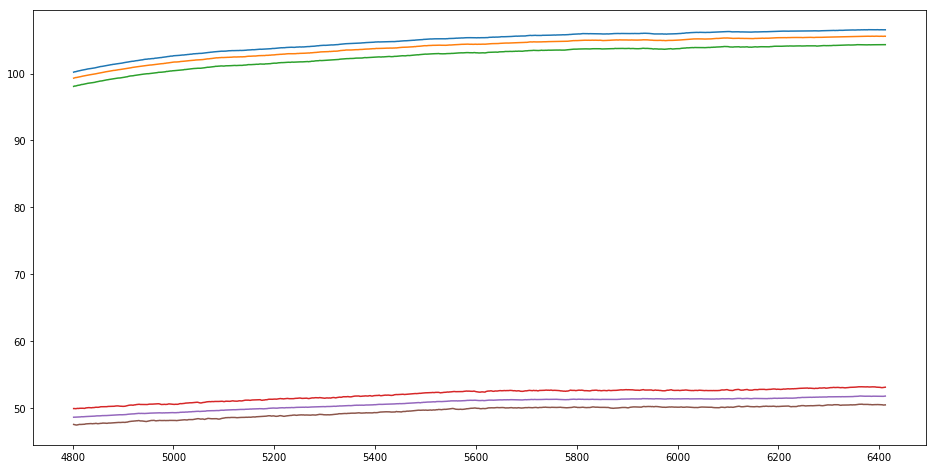

In [57]:
plt.show()

### Calculate and store the steady state temperatures

In [10]:
# Define the areas in the data where the steady state temperatures are
temp_ranges = [
    1000,
    4300,
    3500,
    2400,
]

# Calculate the steady state temperature of each probe for each data set
temps = {}
ave_temps = {}
for m, file_name in enumerate(file_names):
    temps[file_name] = {}
    ave_temps[file_name] = {}
    for i in range(1, 7):
        temps[file_name][i] = [float(row[i]) for row in data[file_name]][temp_ranges[m]:]
        ave_temps[file_name][i] = sum(temps[file_name][i]) / len(temps[file_name][i]) 

In [60]:
ave_temps

{'no_sample/corrected': {1: 74.21844153700468,
  2: 72.96242809104537,
  3: 71.0378647767948,
  4: 61.029986211436544,
  5: 59.307203495430805,
  6: 57.51581525324819},
 'no_sample/erroneous': {1: 71.69341605050224,
  2: 70.48248495279135,
  3: 68.5510495364011,
  4: 59.38412181385509,
  5: 57.4971910680567,
  6: 55.843669605540946},
 'sample/corrected': {1: 104.80980018823969,
  2: 103.84904084312117,
  3: 102.58014849338579,
  4: 52.01028317434912,
  5: 50.67802991464771,
  6: 49.48198787982647},
 'sample/erroneous': {1: 103.92326237605168,
  2: 102.96973341637916,
  3: 101.74640850444416,
  4: 51.32426147670536,
  5: 50.01837333218082,
  6: 48.90793470235971}}

### Calculate the thermal resistances

Figure 1 shows the thermal circuit used to model the thermal resistances of the material stack.

<img src="images/thermal-circuit.png" style="width:650px;">
<br>
<caption><center> <u>**Figure 1**</u>: **Thermal circuit**<br></center></caption>

- $R_1$ is the thermal resistance of the material stack between $T_0$ and $T_1$
- $R_2$ is the thermal resistance of the material stack between $T_1$ and $T_2$
- $R_3$ is the thermal resistance of the interface between $T_2$ and $T_3$
- $R_4$ is the thermal resistance of the material stack between $T_4$ and $T_5$
- $R_5$ is the thermal resistance of the material stack between $T_5$ and $T_6$

Therefore the thermal resistance generalises to

$$R_n = \frac{T_{n+1} - T_{n}}{Q}$$

In [28]:
thermal_resistance = {}
Q = 55  # Electrical power supplied to the heaters (W)
for file_name in file_names:
    thermal_resistance[file_name] = {}
    for i in range(1, 6):
        ave_temp = ave_temps[file_name][i]
        next_ave_temp = ave_temps[file_name][i + 1]
        thermal_resistance[file_name][i] = (ave_temp - next_ave_temp) / Q

In [29]:
thermal_resistance

{'no_sample/corrected': {1: 0.022836608108351118,
  2: 0.034992060259101135,
  3: 0.1819614284610593,
  4: 0.03132332210919525,
  5: 0.03257069531241115},
 'no_sample/erroneous': {1: 0.02201692904928879,
  2: 0.03511700757073196,
  3: 0.1666714131372001,
  4: 0.03430783174178887,
  5: 0.030064026591195548},
 'sample/corrected': {1: 0.0174683517294276,
  2: 0.02307076999518875,
  3: 0.9194520967097577,
  4: 0.024222786540025642,
  5: 0.021746218814931627},
 'sample/erroneous': {1: 0.01733689017586409,
  2: 0.022242271126090816,
  3: 0.916766309595251,
  4: 0.023743420809537046,
  5: 0.020189793269474746}}

### Calculate the thermal conductivity

The thermal conductivity is calculated using the equation

$$k = \frac{l}{R \cdot A}$$

where $l$ is the length of the sample, $R$ is the thermal resistance of the sample and $A$ is the cross-sectional area of the sample.

In [30]:
A = (45e-03)**2
l = 3e-04
with_sample = sum(thermal_resistance['sample/erroneous'].values())
without_sample = sum(thermal_resistance['no_sample/erroneous'].values())
k = l / ((with_sample - without_sample) * A)

print("The thermal conductivity is equal to {} W/mK".format(k))

The thermal conductivity is equal to 0.2080435906354152 W/mK


In [31]:
A = (45e-03)**2
l = 3e-04
diff = (sum(thermal_resistance['sample/corrected'].values()) - sum(thermal_resistance['no_sample/corrected'].values()))
k = l / (diff * A)

print("The thermal conductivity is equal to {} W/mK".format(k))

The thermal conductivity is equal to 0.21095427586929172 W/mK


### Results

The thermal conductivity of the Nomex sample under erroneous conditions is 0.208$Wm^{-1}K^{-1}$.

The thermal conductivity of the Nomex sample under corrected conditions is 0.211$Wm^{-1}K^{-1}$